In [the previous
post](https://mlops.systems/posts/2024-06-02-isafpr-prompting-baseline.html) we
looked at a single example where a prompt could help us extract structured data
from some text. Here were were relying on the inbuilt capabilities of LLMs to
'reason' over the text and the task. In this post we'll try to get a sense of
the overall / aggregate performance of `gpt-4-turbo` on the ISAF Press Releases
data extraction task.

The first thing we need to do is to load and process the data. If you remember
from last time, there were some fields that needed conversion so that we're
comparing apples to apples when we get back our result from the LLM.

## Loading and processing the data

In [26]:
# get data from datasets
from datasets import load_dataset
import pandas as pd
from rich import print
import tqdm as notebook_tqdm

# Load the dataset
dataset = load_dataset("strickvl/isafpressreleases", split="train")

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset)

Resolving data files:   0%|          | 0/4823 [00:00<?, ?it/s]

I'll output the column names as a reference since we'll be using almost all of
these in our evaluation.

In [27]:
df.columns

Index(['name', 'eventrefnumber', 'text', 'StartDate', 'eventtype', 'province',
       'citydistrict', 'village', 'targetgroup', 'commander', 'position',
       'minkilled', 'mincaptured', 'capturedcharacterisation',
       'killedcharacterisation', 'killq', 'captureq', 'killcaptureraid',
       'airstrike', 'noshotsfired', 'dataprocessed', 'flagged', 'glossarymeta',
       'minleaderskilled', 'minfacilitatorskilled', 'minleaderscaptured',
       'minfacilitatorscaptured', 'leaderq'],
      dtype='object')

We set up the same objects to support the Pydantic `IsafEvent` model. This is
the same as last time so I'll hide the code but you can see it by clicking the
popout arrow.

In [28]:
# | code-fold: true
from pydantic import BaseModel, Field
from datetime import date
from enum import Enum


class EventType(str, Enum):
    airstrike = "airstrike"
    detention = "detention"
    captureandkill = "captureandkill"
    insurgentskilled = "insurgentskilled"
    exchangeoffire = "exchangeoffire"
    civiliancasualty = "civiliancasualty"


class Province(str, Enum):
    badakhshan = "badakhshan"
    badghis = "badghis"
    baghlan = "baghlan"
    balkh = "balkh"
    bamyan = "bamyan"
    day_kundi = "day_kundi"
    farah = "farah"
    faryab = "faryab"
    ghazni = "ghazni"
    ghor = "ghor"
    helmand = "helmand"
    herat = "herat"
    jawzjan = "jawzjan"
    kabul = "kabul"
    kandahar = "kandahar"
    kapisa = "kapisa"
    khost = "khost"
    kunar = "kunar"
    kunduz = "kunduz"
    laghman = "laghman"
    logar = "logar"
    nangarhar = "nangarhar"
    nimroz = "nimroz"
    nuristan = "nuristan"
    paktia = "paktia"
    paktika = "paktika"
    panjshir = "panjshir"
    parwan = "parwan"
    samangan = "samangan"
    sar_e_pol = "sar_e_pol"
    takhar = "takhar"
    uruzgan = "uruzgan"
    wardak = "wardak"
    zabul = "zabul"


class TargetGroup(str, Enum):
    taliban = "taliban"
    haqqani = "haqqani"
    criminals = "criminals"
    aq = "aq"
    hig = "hig"
    let = "let"
    imu = "imu"
    judq = "judq"
    iju = "iju"
    hik = "hik"
    ttp = "ttp"
    other = "other"

Our `IsafEvent` is what we're trying to get to. We want to turn an unstructured
piece of text (a press release) into the structured format you see below.

In [29]:
from typing import Set


class IsafEvent(BaseModel):
    name: str = Field(
        description="A title or name for the event which summarises the event as a headline"
    )
    start_date: date = Field(
        description="The start date of the event in YYYY-MM-DD format"
    )
    event_type: Set[EventType] = Field(
        description="The event type. Can be multiple types."
    )
    province: Set[Province] = Field(
        description="The province in which the event occurred. Can be multiple provinces."
    )
    target_group: Set[TargetGroup] = Field(
        description="The group that was targetted during the event. Can be multiple groups."
    )
    min_killed: int = Field(
        description="The minimum number of people killed during the event"
    )
    min_captured: int = Field(
        description="The minimum number of people captured during the event"
    )
    killq: bool = Field(
        description="Whether someone was killed or not during the event"
    )
    captureq: bool = Field(
        description="Whether someone was captured or not during the event"
    )
    killcaptureraid: bool = Field(
        description="Whether the event was a so-called 'kill-capture raid'."
    )
    airstrike: bool = Field(
        description="Whether an airstrike was used during the event"
    )
    noshotsfired: bool = Field(
        description="Whether no shots were fired during the event"
    )
    min_leaders_killed: int = Field(
        description="The minimum number of leaders killed during the event"
    )
    min_leaders_captured: int = Field(
        description="The minimum number of leaders captured during the event"
    )

    class Config:
        arbitrary_types_allowed = True

Again we can take a look at a single example to understand the task and to
construct our first evaluation of this single example. The article looks like this:

In [51]:
article_id = 15
article_text = df["text"][article_id]
print(article_text)

Dec. 11: Haqqani Facilitator Detained in Khowst; Security Discussed in Farah
NEWS RELEASE ISAF Joint Command - Afghanistan   2009-12-CA-065 For Immediate Release  KABUL, Afghanistan (Dec. 11) - An
Afghan-international security force detained a couple of militants in Khowst province today, one of whom was a 
sought-after Haqqani facilitator.  The facilitator is responsible for the shipment and distribution of weapons to 
other militant elements in the area.
 The joint security force searched a compound near the village of Badal Kalay in the Nader Shakhot district where 
intelligence sources indicated the facilitator was located.  The facilitator identified himself and surrendered 
without incident.  No shots were fired and no one was injured.

And our prompt looks like this:

In [52]:
query = f"""
The following is a press release issued by ISAF (formerly operating in Afghanistan):
{article_text}

Please extract the following information from the press release:
- The name of the event (summarising the event / text as a headline)
- The start date of the event
- The event type(s)
- The province(s) in which the event occurred
- The target group(s) of the event
- The minimum number of people killed during the event
- The minimum number of people captured during the event
- Whether someone was killed or not during the event
- Whether someone was captured or not during the event
- Whether the event was a so-called 'kill-capture raid'
- Whether an airstrike was used during the event
- Whether no shots were fired during the event
- The minimum number of leaders killed during the event
- The minimum number of leaders captured during the event

Annotation notes:
- A 'faciliator' is not a leader.
- If a press release states that 'insurgents' were detained without further details, assign a minimum number of two detained. Interpret 'a couple' as two. Interpret 'several' as at least three, even though it may sometimes refer to seven or eight. Classify the terms 'a few', 'some', 'a group', 'a small group', and 'multiple' as denoting at least three, even if they sometimes refer to larger numbers. Choose the smaller number if no other information is available in the press release to come up with a minimally acceptable figure. Interpret 'numerous' and 'a handful' as at least four, and 'a large number' as at least five.
"""

Since we're going to be doing a lot of LLM calls I took a moment to refactor the
code to make it less verbose. Click through to see the full code for the
`query_llm` but basically it's just a wrapper around OpenAI, Anthropic and
Ollama models and we route to one or the other of those depending on what model
you say you want to use.

In [53]:
# | code-fold: true
import instructor
from anthropic import Anthropic
from openai import OpenAI


def query_llm(message: str, model: str, response_model: BaseModel) -> str:
    if model in ["gpt-4", "gpt-4-turbo-preview", "gpt-4-turbo"]:
        client = instructor.patch(OpenAI(), mode=instructor.Mode.JSON)

        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": message,
                },
            ],
            response_model=response_model,
            max_retries=3,
        )
    elif model in ["claude-3-opus-20240229", "claude-3-opus-20240229-preview"]:
        client = instructor.from_anthropic(Anthropic())

        # note that client.chat.completions.create will also work
        response = client.messages.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": message,
                },
            ],
            max_tokens=4096,
            response_model=response_model,
            max_retries=3,
        )
    elif model in ["mistral", "mixtral", "llama-3", "gemma", "gemma:2b"]:
        client = instructor.from_openai(
            OpenAI(
                base_url="http://localhost:11434/v1",
                api_key="ollama",  # required, but unused
            ),
            mode=instructor.Mode.JSON,
        )

        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": message,
                }
            ],
            response_model=response_model,
        )
    return response

And here are the responses for `gpt-4-turbo` and `claude-3-opus-20240229`.

In [54]:
openai_response = query_llm(query, "gpt-4-turbo", IsafEvent)
print(openai_response)

IsafEvent(
    name='Haqqani Facilitator Detained in Khowst',
    start_date=datetime.date(2009, 12, 11),
    event_type={<EventType.detention: 'detention'>},
    province={<Province.khost: 'khost'>},
    target_group={<TargetGroup.haqqani: 'haqqani'>},
    min_killed=0,
    min_captured=2,
    killq=False,
    captureq=True,
    killcaptureraid=False,
    airstrike=False,
    noshotsfired=True,
    min_leaders_killed=0,
    min_leaders_captured=0
)

In [55]:
claude_response = query_llm(query, "claude-3-opus-20240229", IsafEvent)
print(claude_response)

IsafEvent(
    name='Haqqani Facilitator Detained in Khowst',
    start_date=datetime.date(2009, 12, 11),
    event_type={<EventType.detention: 'detention'>},
    province={<Province.khost: 'khost'>},
    target_group={<TargetGroup.haqqani: 'haqqani'>},
    min_killed=0,
    min_captured=2,
    killq=False,
    captureq=True,
    killcaptureraid=False,
    airstrike=False,
    noshotsfired=True,
    min_leaders_killed=0,
    min_leaders_captured=0
)

Unfortunately I was unable to evaluate a local model for this task as I couldn't
get a response back. I just got a Pydantic validation error, suggesting to me
that maybe we're hitting the context length limits of those local models with all the extra metadata in the JSON schema that we're passing in
via `instructor`. At any rate for now it's the first immediate validation of the
idea to finetune the model if we're already hitting the limits of raw prompting
for those models.

## Evaluating the results

We'll want some kind of object to store our evaluation results and you can see
all the fields I selected below. For fields where we can say 'true' or 'false'
then I just did that, but for fields with multiple options then I thought a
`float` value from 0 to 1 representing how 'correct' the options were would be
the best option.

For fields with numeric values (i.e. number of killed individuals etc) then I
generally created two fields: one was just a boolean field for whether it was
correct and then another which was the distance between the annotated value and
the value we predicted.

In [56]:
class EvalResult(BaseModel):
    start_date_correct: bool = Field(
        description="Whether the start date of the event is correct"
    )
    event_type_score: float = Field(
        description="The score between 0 and 1 for the event type of the event"
    )
    province_score: float = Field(
        description="The score between 0 and 1 for the province of the event"
    )
    target_group_score: float = Field(
        description="The score between 0 and 1 for the target group of the event"
    )
    min_killed_correct: bool = Field(
        description="Whether the minimum number of people killed during the event is correct"
    )
    min_killed_distance: int = Field(
        description="The distance between the minimum number of people killed during the event and the annotated number of people killed during the event"
    )
    min_captured_correct: bool = Field(
        description="Whether the minimum number of people captured during the event is correct"
    )
    min_captured_distance: int = Field(
        description="The distance between the minimum number of people captured during the event and the annotated number of people captured during the event"
    )
    killq_correct: bool = Field(description="Whether the 'killq' field is correct")
    captureq_correct: bool = Field(
        description="Whether the 'captureq' field is correct"
    )
    killcaptureraid_correct: bool = Field(
        description="Whether the 'killcaptureraid' field is correct"
    )
    airstrike_correct: bool = Field(
        description="Whether the 'airstrike' field is correct"
    )
    noshotsfired_correct: bool = Field(
        description="Whether the 'noshotsfired' field is correct"
    )
    min_leaders_killed_correct: bool = Field(
        description="Whether the minimum number of leaders killed during the event is correct"
    )
    min_leaders_killed_distance: int = Field(
        description="The distance between the minimum number of leaders killed during the event and the annotated number of leaders killed during the event"
    )
    min_leaders_captured_correct: bool = Field(
        description="Whether the minimum number of leaders captured during the event is correct"
    )
    min_leaders_captured_distance: int = Field(
        description="The distance between the minimum number of leaders captured during the event and the annotated number of leaders captured during the event"
    )

I then coded up some methods that would calculate the score for each of the
fields. Once again, there's a decent amount of code here so I'll fold it away
and you can unfold the code if you want to take a look.

In [57]:
# | code-fold: true
def start_date_correct(start_date: date, correct_date: date) -> bool:
    return start_date == correct_date.date()


def event_type_score(event_type: Set[EventType], correct_event_types: str) -> float:
    # Convert the correct event types string to a set of EventType enum values
    correct_event_types_set = set(EventType(t) for t in correct_event_types.split(";"))

    # Calculate the number of correct predictions
    correct_predictions = len(event_type.intersection(correct_event_types_set))

    # Calculate the total number of correct event types
    total_correct_types = len(correct_event_types_set)

    # Calculate the accuracy percentage
    if total_correct_types > 0:
        accuracy = correct_predictions / total_correct_types
    else:
        accuracy = 0.0

    return accuracy


def province_score(province: Set[Province], correct_province: str) -> float:
    # Convert the correct province string to a set of Province enum values
    correct_province_set = set()
    invalid_provinces = set()
    for p in correct_province.split(";"):
        try:
            correct_province_set.add(Province(p.lower()))
        except ValueError:
            invalid_provinces.add(p.lower())

    # Calculate the number of correct predictions
    correct_predictions = len(province.intersection(correct_province_set))

    # Calculate the total number of provinces
    total_provinces = len(correct_province_set) + len(invalid_provinces)

    # Calculate the accuracy percentage
    if total_provinces > 0:
        accuracy = correct_predictions / total_provinces
    else:
        accuracy = 0.0

    return accuracy


def target_group_score(
    target_group: Set[TargetGroup], correct_target_group: str
) -> float:
    # Handle the case where correct_target_group is an empty string
    if correct_target_group.strip() == "":
        correct_target_group_set = set()
    else:
        # Convert the correct target group string to a set of TargetGroup enum values
        correct_target_group_set = set(
            TargetGroup(t.lower()) for t in correct_target_group.split(";")
        )

    # Calculate the number of correct predictions
    correct_predictions = len(target_group.intersection(correct_target_group_set))

    # Calculate the total number of correct target groups
    total_correct_target_groups = len(correct_target_group_set)

    # Calculate the accuracy percentage
    if total_correct_target_groups > 0:
        accuracy = correct_predictions / total_correct_target_groups
    else:
        accuracy = 0.0

    return accuracy


def min_killed_correct(min_killed: int, correct_min_killed: str) -> bool:
    return min_killed == int(correct_min_killed)


def min_killed_distance(min_killed: int, correct_min_killed: str) -> int:
    return abs(min_killed - int(correct_min_killed))


def min_captured_correct(min_captured: int, correct_min_captured: str) -> bool:
    return min_captured == int(correct_min_captured)


def min_captured_distance(min_captured: int, correct_min_captured: str) -> int:
    return abs(min_captured - int(correct_min_captured))


def killq_correct(killq: bool, correct_killq: str) -> bool:
    return killq == (correct_killq == "true")


def captureq_correct(captureq: bool, correct_captureq: str) -> bool:
    return captureq == (correct_captureq == "true")


def killcaptureraid_correct(
    killcaptureraid: bool, correct_killcaptureraid: str
) -> bool:
    return killcaptureraid == (correct_killcaptureraid == "true")


def airstrike_correct(airstrike: bool, correct_airstrike: str) -> bool:
    return airstrike == (correct_airstrike == "true")


def noshotsfired_correct(noshotsfired: bool, correct_noshotsfired: str) -> bool:
    return noshotsfired == (correct_noshotsfired == "true")


def min_leaders_killed_correct(
    min_leaders_killed: int, correct_min_leaders_killed: str
) -> bool:
    return min_leaders_killed == int(correct_min_leaders_killed)


def min_leaders_killed_distance(
    min_leaders_killed: int, correct_min_leaders_killed: str
) -> int:
    return abs(min_leaders_killed - int(correct_min_leaders_killed))


def min_leaders_captured_correct(
    min_leaders_captured: int, correct_min_leaders_captured: str
) -> bool:
    return min_leaders_captured == int(correct_min_leaders_captured)


def min_leaders_captured_distance(
    min_leaders_captured: int, correct_min_leaders_captured: str
) -> int:
    return abs(min_leaders_captured - int(correct_min_leaders_captured))

I then wrote a function which could generate one of these `EvalResult` objects
given a response from an LLM, the original dataframe (with the ground truth
annotations) and the article id of the row.

You can see how Claude 3 Opus and GPT-4 Turbo performed on our single article below:

In [58]:
def evaluate_llm_response(
    response: IsafEvent, df: pd.DataFrame, article_id: int
) -> EvalResult:
    return EvalResult(
        start_date_correct=start_date_correct(
            response.start_date, df["StartDate"][article_id]
        ),
        event_type_score=event_type_score(
            response.event_type, df["eventtype"][article_id]
        ),
        province_score=province_score(response.province, df["province"][article_id]),
        target_group_score=target_group_score(
            response.target_group, df["targetgroup"][article_id]
        ),
        min_killed_correct=min_killed_correct(
            response.min_killed, df["minkilled"][article_id]
        ),
        min_killed_distance=min_killed_distance(
            response.min_killed, df["minkilled"][article_id]
        ),
        min_captured_correct=min_captured_correct(
            response.min_captured, df["mincaptured"][article_id]
        ),
        min_captured_distance=min_captured_distance(
            response.min_captured, df["mincaptured"][article_id]
        ),
        killq_correct=killq_correct(response.killq, df["killq"][article_id]),
        captureq_correct=captureq_correct(
            response.captureq, df["captureq"][article_id]
        ),
        killcaptureraid_correct=killcaptureraid_correct(
            response.killcaptureraid, df["killcaptureraid"][article_id]
        ),
        airstrike_correct=airstrike_correct(
            response.airstrike, df["airstrike"][article_id]
        ),
        noshotsfired_correct=noshotsfired_correct(
            response.noshotsfired, df["noshotsfired"][article_id]
        ),
        min_leaders_killed_correct=min_leaders_killed_correct(
            response.min_leaders_killed, df["minleaderskilled"][article_id]
        ),
        min_leaders_killed_distance=min_leaders_killed_distance(
            response.min_leaders_killed, df["minleaderskilled"][article_id]
        ),
        min_leaders_captured_correct=min_leaders_captured_correct(
            response.min_leaders_captured, df["minleaderscaptured"][article_id]
        ),
        min_leaders_captured_distance=min_leaders_captured_distance(
            response.min_leaders_captured, df["minleaderscaptured"][article_id]
        ),
    )


print("Claude 3 Opus Scores")
print(evaluate_llm_response(claude_response, df, article_id))
print("GPT-4 Turbo Scores")
print(evaluate_llm_response(openai_response, df, article_id))

Claude 3 Opus Scores

EvalResult(
    start_date_correct=True,
    event_type_score=1.0,
    province_score=1.0,
    target_group_score=1.0,
    min_killed_correct=True,
    min_killed_distance=0,
    min_captured_correct=True,
    min_captured_distance=0,
    killq_correct=True,
    captureq_correct=True,
    killcaptureraid_correct=False,
    airstrike_correct=True,
    noshotsfired_correct=True,
    min_leaders_killed_correct=True,
    min_leaders_killed_distance=0,
    min_leaders_captured_correct=True,
    min_leaders_captured_distance=0
)

GPT-4 Turbo Scores

EvalResult(
    start_date_correct=True,
    event_type_score=1.0,
    province_score=1.0,
    target_group_score=1.0,
    min_killed_correct=True,
    min_killed_distance=0,
    min_captured_correct=True,
    min_captured_distance=0,
    killq_correct=True,
    captureq_correct=True,
    killcaptureraid_correct=False,
    airstrike_correct=True,
    noshotsfired_correct=True,
    min_leaders_killed_correct=True,
    min_leaders_killed_distance=0,
    min_leaders_captured_correct=True,
    min_leaders_captured_distance=0
)

At first glance it looks like our models performed pretty well. Both got
the `killcaptureraid` status of the article wrong, but otherwise almost perfect
across the board.

Doing this one by one is tedious, of course, and really what we want is an
evaluation across a random slice of our articles. So let's do that next.

## Evaluating in aggregate

Here we'll shuffle our dataframe to take a random sample of our articles, then
we'll iterate over 100 of our rows to get the generated responses for GPT-4.
We'll also time how long it takes to execute the cell so as to have some kind of
benchmark for how long the inference takes. We can use that later on to try to
beat this baseline.

In [40]:
%%time

# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=42)

openai_responses = {}

# Iterate over the first 5 rows of the shuffled DataFrame
for index, row in shuffled_df.head(100).iterrows():
    openai_responses[index] = query_llm(row["text"], "gpt-4-turbo", IsafEvent)

CPU times: user 2.53 s, sys: 34.4 ms, total: 2.57 s
Wall time: 10min 4s


As you can see, this took a total of 10 minutes to run so on average this was
around 6 seconds per article. Some articles will be longer than others, of
course, so perhaps the aggregate '10 minutes per 100 articles' is a better metric.

We now have our results in memory in the `openai_responses` dictionary. We can
now calculate the scores for the results and plot them.

In [49]:
from typing import List
import matplotlib.pyplot as plt


def calculate_scores(eval_results: List[EvalResult]) -> dict:
    scores = {}
    total_count = len(eval_results)

    for attr in EvalResult.__fields__:
        if attr.endswith("_score"):
            scores[attr] = (
                sum(getattr(result, attr) for result in eval_results) / total_count
            )
        elif attr.endswith("_correct"):
            scores[attr] = (
                sum(getattr(result, attr) for result in eval_results) / total_count
            )
        elif attr.endswith("_distance"):
            if attr == "min_captured_distance":
                capped_values = [
                    min(max(getattr(result, attr), 0), 1) for result in eval_results
                ]
                scores[attr] = 1 - (sum(capped_values) / total_count)
            else:
                scores[attr] = 1 - (
                    sum(getattr(result, attr) for result in eval_results) / total_count
                )

    return scores


def plot_scores(scores: dict):
    attributes = list(scores.keys())
    values = [score * 100 for score in scores.values()]  # Convert scores to percentages

    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size

    ax.barh(attributes, values)
    ax.set_xlim(0, 100)  # Set x-axis range from 0 to 100
    ax.set_xlabel("Score (%)")
    ax.set_ylabel("Attribute")
    ax.set_title("GPT-4 Turbo Evaluation Scores")

    for i, v in enumerate(values):
        ax.text(v + 1, i, f"{v:.2f}%", va="center")  # Add percentage symbol to labels

    # Adjust the left margin to remove extra white space
    plt.subplots_adjust(left=0.2)

    plt.show()

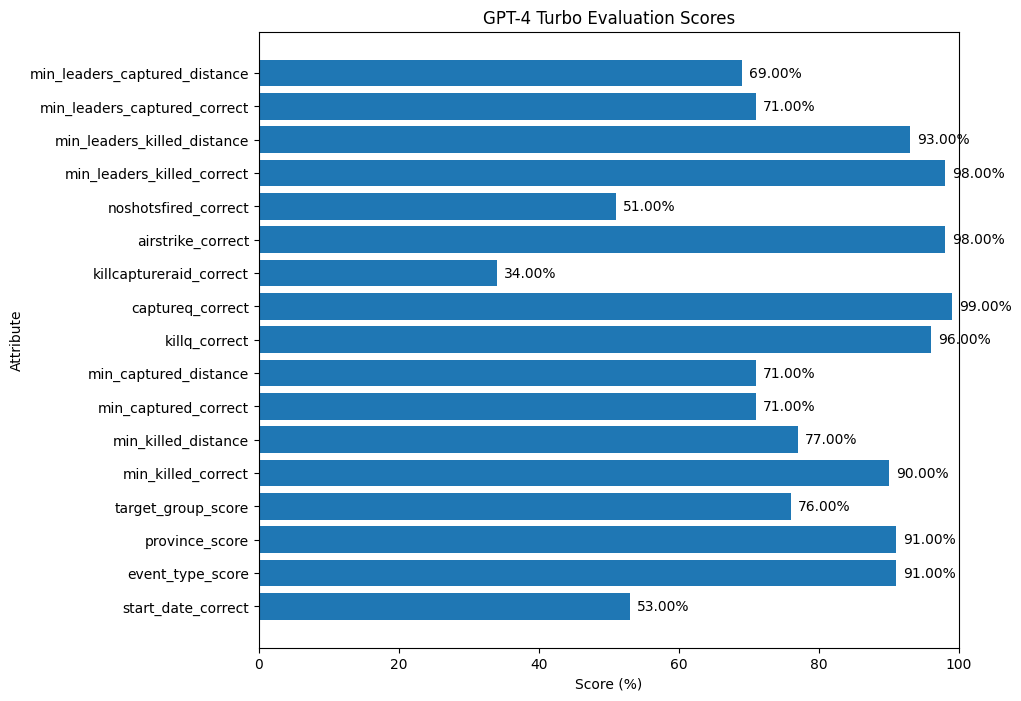

In [50]:
eval_results = []
for article_id, response in openai_responses.items():
    eval_results.append(evaluate_llm_response(response, df, article_id))
scores = calculate_scores(eval_results)
plot_scores(scores)

This gives us a nice overview of how a mostly-unoptimised approach that just
pairs prompting with `instructor` (i.e. passing in the JSON schema for our
expected results) performs on our data. Some scores are pretty good,
particularly where it's just a boolean we're getting back. For others involving
numbers (i.e. numbers of killed or captured) we have much lower scores.

The lowest performing score is the check as to whether the text describes a
`killcaptureraid`. Our prompt doesn't really give much explanation or context as
to how we determined this in the original dataset, so maybe an example or two in
the prompt would help there.

So overall, `gpt-4-turbo` performs moderately well, but this wouldn't be
acceptable for the purposes of the report that I wrote. The assumption there was
that the data was labelled more or less perfectly since I used that data to make
accusations and claims about the international military presence in Afghanistan.
It simply wouldn't be good enough to say that we 'mostly' got the right numbers
when extracting the data from the text. We needed a really high accuracy across
the board.

If I was doing this properly the obvious next step would be to try to split up
the task into discrete / focused parts as I mentioned in [the previous
post](https://mlops.systems/posts/2024-06-02-isafpr-prompting-baseline.html).
That way we could let the model take multiple shots at the problem and have less
to handle overall in any one reading. I might return to that at a later stage
because that might be the way forward with our finetuning work as well (to get
best in class results).

For now, though, the next step is to prepare our data
for finetuning and then to actually run the finetuning. My preference is to
select a base model which I can train on my local machine, but since we do have
lots of credits with a variety of cloud providers I'll try to run my finetuning
on more powerful machines in the cloud as well.
